100%|██████████| 1000/1000 [00:21<00:00, 47.06it/s]


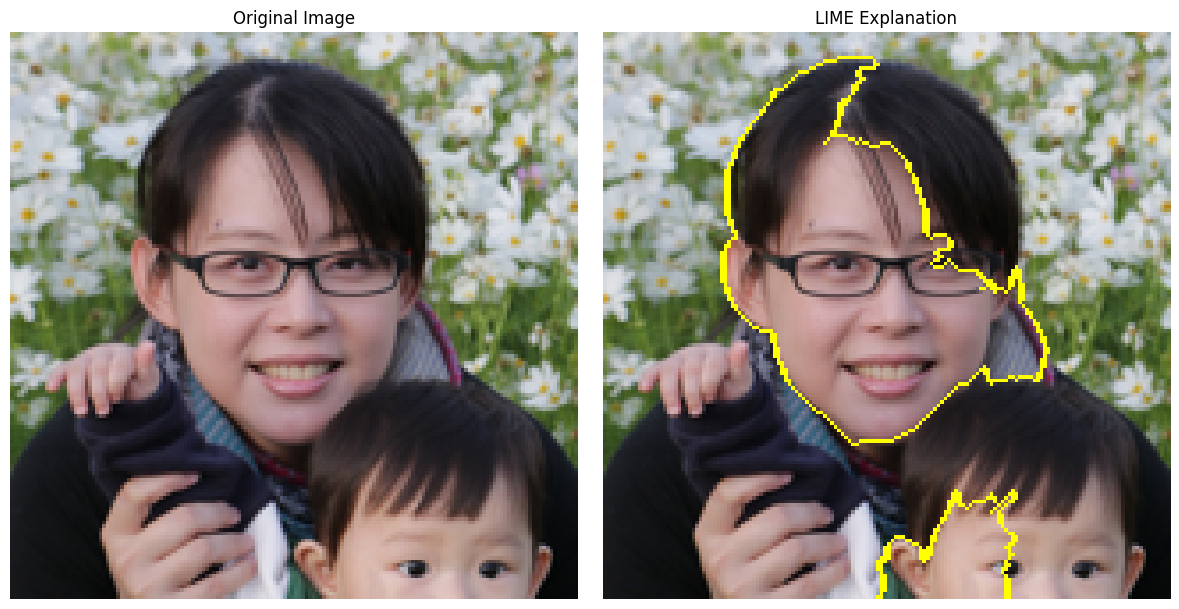

In [62]:

from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision import models

# Load the FaceNet model
from util.facenet_model import model as facenet_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = facenet_model.to(device)
model.load_state_dict(torch.load("facenet_classifier.pth", map_location=device))
model.eval()

# Constants for normalization
FACE_IMG_MEAN = [0.5, 0.5, 0.5]
FACE_IMG_STD = [0.5, 0.5, 0.5]
NUM_FACE_CLASSES = 5  # Based on the dataset we saw in the code

# Preprocessing and inverse normalization
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=FACE_IMG_MEAN, std=FACE_IMG_STD)
])

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(FACE_IMG_MEAN, FACE_IMG_STD)],
    std=[1/s for s in FACE_IMG_STD]
)

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

# LIME prediction wrapper
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(img)).to(device) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

# Run LIME explanation and plot original + explanation side by side
def explain_image(image_path):
    explainer = lime_image.LimeImageExplainer()
    img = Image.open(image_path).convert("RGB").resize((160, 160))
    img_np = np.array(img)

    explanation = explainer.explain_instance(
        img_np, 
        batch_predict, 
        top_labels=1, 
        hide_color=0, 
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Plot original and LIME explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Original image
    axes[0].imshow(img_np)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    # LIME explanation
    axes[1].imshow(mark_boundaries(temp, mask))
    axes[1].axis("off")
    axes[1].set_title("LIME Explanation")
    plt.tight_layout()
    plt.show()

# Example usage
explain_image("data/101506130@N03_identity_0@10902564096_0.jpg")


In [64]:
import numpy as np
import torch
from tqdm import tqdm

def compute_insertion_deletion_curve(image, mask, model, transform, device, steps=100, target_label=None, batch_size=16):
    """
    Computes insertion and deletion curves for a single image and mask.
    Returns the list of confidences for insertion and deletion.
    """
    img = np.array(image)
    if img.max() > 1:
        img = img / 255.0

    # Flatten mask and sort indices by importance
    flat_mask = mask.flatten()
    sorted_indices = np.argsort(-flat_mask)  # descending order

    h, w = mask.shape
    total_pixels = h * w

    # Prepare insertion and deletion images
    insertion = np.zeros_like(img)
    deletion = img.copy()

    insertion_scores = []
    deletion_scores = []

    # Get the original prediction
    input_tensor = transform(Image.fromarray((img * 255).astype(np.uint8))).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
    if target_label is None:
        target_label = np.argmax(probs)
    orig_conf = probs[target_label]

    # Prepare batch indices for efficiency
    for step in range(0, total_pixels + 1, max(1, total_pixels // steps)):
        # Insertion: add top-k important pixels
        insertion_img = insertion.copy()
        if step > 0:
            inds = sorted_indices[:step]
            insertion_img.reshape(-1, 3)[inds] = img.reshape(-1, 3)[inds]
        # Deletion: remove top-k important pixels
        deletion_img = deletion.copy()
        if step > 0:
            inds = sorted_indices[:step]
            deletion_img.reshape(-1, 3)[inds] = 0

        # Stack for batch prediction
        batch_imgs = [
            (insertion_img * 255).astype(np.uint8),
            (deletion_img * 255).astype(np.uint8)
        ]
        batch = torch.stack([transform(Image.fromarray(im)).to(device) for im in batch_imgs], dim=0)
        with torch.no_grad():
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        insertion_scores.append(probs[0, target_label])
        deletion_scores.append(probs[1, target_label])

    return np.array(insertion_scores), np.array(deletion_scores), orig_conf, target_label

def auc(arr):
    """Compute normalized AUC using the trapezoidal rule."""
    return np.trapz(arr) / (len(arr) - 1)

def batch_lime_metrics(image_paths, model, transform, device, lime_explainer, num_samples=1000, num_features=5, steps=100):
    """
    Compute LIME explanation metrics for a batch of images.
    Returns dict with IAUC, DAUC, insertion/deletion correlation, average drop, increase in confidence.
    """
    IAUCs, DAUCs, ins_corrs, del_corrs, avg_drops, inc_confs = [], [], [], [], [], []

    # Use tqdm to show a single progress bar for all images
    for image_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(image_path).convert("RGB").resize((160, 160))
        img_np = np.array(img)

        # LIME explanation
        explanation = lime_explainer.explain_instance(
            img_np,
            lambda x: batch_predict(x),
            top_labels=1,
            hide_color=0,
            num_samples=num_samples
        )
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=num_features,
            hide_rest=False
        )
        # mask is 2D, values in {0,1,...,num_features}
        # We'll use the mask as importance: higher value = more important
        # For correlation, flatten mask and use as importance
        mask_importance = mask.astype(float)

        # Compute insertion/deletion curves
        ins_scores, del_scores, orig_conf, target_label = compute_insertion_deletion_curve(
            img_np, mask_importance, model, transform, device, steps=steps, target_label=explanation.top_labels[0]
        )

        # IAUC/DAUC
        IAUCs.append(auc(ins_scores))
        DAUCs.append(auc(1 - del_scores))

        # Insertion/Deletion correlation: correlation between mask importance and confidence change
        # For insertion: importance vs. confidence gain at each step
        importance_flat = mask_importance.flatten()
        # For each step, the number of pixels revealed is step
        # So, for each pixel, its order in sorted_indices is its importance rank
        sorted_indices = np.argsort(-importance_flat)
        pixel_ranks = np.empty_like(sorted_indices)
        pixel_ranks[sorted_indices] = np.arange(len(sorted_indices))
        # Confidence at each step: ins_scores, del_scores
        # Correlate pixel rank with confidence change
        ins_corr = np.corrcoef(pixel_ranks, np.interp(pixel_ranks, np.linspace(0, len(pixel_ranks)-1, len(ins_scores)), ins_scores))[0,1]
        del_corr = np.corrcoef(pixel_ranks, np.interp(pixel_ranks, np.linspace(0, len(pixel_ranks)-1, len(del_scores)), del_scores))[0,1]
        ins_corrs.append(ins_corr)
        del_corrs.append(del_corr)

        # Average Drop: (original_conf - max_conf_with_masked) / original_conf
        max_conf = np.max(ins_scores)
        avg_drop = max(0, (orig_conf - max_conf) / orig_conf)
        avg_drops.append(avg_drop)

        # Increase in Confidence: 1 if max_conf > orig_conf else 0
        inc_conf = 1 if max_conf > orig_conf else 0
        inc_confs.append(inc_conf)

    metrics = {
        "IAUC Score": np.mean(IAUCs),
        "DAUC Score": np.mean(DAUCs),
        "Insertion Correlation": np.mean(ins_corrs),
        "Deletion Correlation": np.mean(del_corrs),
        "Average Drop": np.mean(avg_drops),
        "Increase in Confidence": np.mean(inc_confs)
    }
    return metrics

# Example usage:
import glob

# Get all image file paths in the 'data' directory (adjust the pattern if needed)
image_paths = glob.glob("data/*.*")  # or use "data/*.jpg" if only jpgs

metrics = batch_lime_metrics(image_paths, model, transform, device, lime_image.LimeImageExplainer())
print(metrics)


Processing images: 100%|██████████| 56/56 [28:34<00:00, 30.61s/it]

{'IAUC Score': 0.5945085508482798, 'DAUC Score': 0.8033413587297712, 'Insertion Correlation': 0.3881066785839211, 'Deletion Correlation': -0.20295736996496494, 'Average Drop': 1.1519486317216172e-09, 'Increase in Confidence': 0.8928571428571429}
